In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [22]:
import matplotlib
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fm.get_fontconfig_fonts()
font_location = 'C:\\Windows\\Fonts\malgun.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

import seaborn as sns

In [2]:
dataset = pd.read_excel('../data/4/result/dataset.xlsx', dtype={'시군구코드':str})
dataset.head()

,시도,시군구,시군구코드,시점,SDI,총인구수,영유아_어린이_인구_비율,청소년_인구_비율,고령인구_비율,여성인구비율,...,대출권수_철학,대출권수_종교,대출권수_사회과학,대출권수_순수과학,대출권수_기술과학,대출권수_예술,대출권수_언어,대출권수_문학,대출권수_역사,대출권수
0,서울특별시,종로구,11010,2014,-2.415031,153407.0,0.107036,0.059443,0.146506,0.504817,...,57775.0,28488.0,67570.0,129495.0,68750.0,80978.0,60915.0,525713.0,144547.0,1158860.0
1,서울특별시,중구,11020,2014,-2.362601,125273.0,0.103538,0.047456,0.145291,0.500714,...,29961.0,10694.0,21776.0,24487.0,41994.0,60358.0,33925.0,219835.0,50810.0,480436.0
2,서울특별시,용산구,11030,2014,-2.640132,229055.0,0.119022,0.051581,0.137262,0.513246,...,38235.0,16553.0,34964.0,42344.0,65563.0,47178.0,42155.0,282404.0,61587.0,615193.0
3,서울특별시,성동구,11040,2014,-1.988008,292786.5,0.122975,0.053449,0.118708,0.502542,...,159147.0,86455.0,117240.0,322500.0,197439.0,120522.0,250845.0,2049698.0,353931.0,3586468.0
4,서울특별시,광진구,11050,2014,-1.823281,361146.5,0.118682,0.060341,0.102618,0.508316,...,53339.0,14892.0,39561.0,96258.0,78661.0,42233.0,73782.0,549955.0,114378.0,1048389.0


In [3]:
sgg_gdf = gpd.gpd.GeoDataFrame.from_file('../data/0/shp/sgg.shp', encoding='UTF-8', crs="epsg:4326")
sgg_gdf = sgg_gdf.astype({'SGG_AD_CD':str,'SGG_LE_CD':str})
sgg_gdf.head()

,SGG_AD_CD,SGG_LE_CD,SIDO,SGG,geometry
0,11010,11110,서울특별시,종로구,"POLYGON ((126.94890 37.62325, 126.94890 37.623..."
1,11020,11140,서울특별시,중구,"POLYGON ((126.96155 37.55860, 126.96155 37.558..."
2,11030,11170,서울특별시,용산구,"POLYGON ((126.94459 37.53378, 126.94460 37.533..."
3,11040,11200,서울특별시,성동구,"POLYGON ((127.00815 37.54506, 127.00817 37.545..."
4,11050,11215,서울특별시,광진구,"POLYGON ((127.05622 37.52832, 127.05623 37.528..."


## Moran's I

In [4]:
import libpysal
from libpysal.weights.contiguity import Queen

from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

In [5]:
year = 2015

year_data = dataset.loc[dataset['시점']==year].reset_index()
#year_data['1인당_대출권수'] = year_data['대출권수'] / year_data['총인구수'] 
year_data['도서관_1관당_대출권수'] = year_data['대출권수'] / year_data['도서관수'] 

#year_data['대출권수'] = np.log(year_data['대출권수'])

year_data_visu = gpd.GeoDataFrame(pd.merge(sgg_gdf, year_data[['시군구코드','도서관_1관당_대출권수','SDI']], left_on ='SGG_AD_CD', right_on='시군구코드', how='inner'))
year_data_visu = year_data_visu.set_crs('epsg:4326').to_crs('epsg:4326')
year_data_visu.head()

,SGG_AD_CD,SGG_LE_CD,SIDO,SGG,geometry,시군구코드,도서관_1관당_대출권수,SDI
0,11010,11110,서울특별시,종로구,"POLYGON ((126.94890 37.62325, 126.94890 37.623...",11010,235689.000000,-2.358770
1,11020,11140,서울특별시,중구,"POLYGON ((126.96155 37.55860, 126.96155 37.558...",11020,118767.000000,-2.346437
2,11030,11170,서울특별시,용산구,"POLYGON ((126.94459 37.53378, 126.94460 37.533...",11030,202272.000000,-2.819427
3,11040,11200,서울특별시,성동구,"POLYGON ((127.00815 37.54506, 127.00817 37.545...",11040,131997.666667,-2.061491
4,11050,11215,서울특별시,광진구,"POLYGON ((127.05622 37.52832, 127.05623 37.528...",11050,308105.000000,-1.741621


In [7]:
import shapely

polygons = [shapely.wkt.loads(shapely.wkt.dumps(poly, rounding_precision=4)) for poly in year_data_visu['geometry']]
w_queen = Queen(polygons)

w_queen.transform = 'r'

('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 183, ' is an island (no neighbors)')
('WARNING: ', 184, ' is an island (no neighbors)')
('WARNING: ', 208, ' is an island (no neighbors)')
('WARNING: ', 214, ' is an island (no neighbors)')
('WARNING: ', 221, ' is an island (no neighbors)')


In [12]:
kd = libpysal.cg.KDTree(np.array([(cent.x, cent.y) for cent in year_data_visu['geometry'].to_crs('epsg:5179').centroid]))
w = libpysal.weights.KNN(kd, 1)
w.transform = 'r'

C:\Users\rkddn\.conda\envs\ox\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 48 disconnected components.
  warnings.warn(message)


In [19]:
from libpysal.weights import W

wq_n, wq_w = w_queen.neighbors, w_queen.weights
w_n, w_w = w.neighbors, w.weights

for key in wq_n.keys():
    if (len(wq_n[key])==0):
        wq_n[key] = w_n[key]
        wq_w[key] = w_w[key]
        
w_new = W(wq_n, wq_w)

C:\Users\rkddn\.conda\envs\ox\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [28]:
y1 = year_data_visu['도서관_1관당_대출권수'].values
y2 = year_data_visu['SDI'].values

moran1 = Moran(y1, w_new, permutations = 95)
moran2 = Moran(y2, w_new, permutations = 95)

moran1.I, moran2.I

(0.40915335632144345, 0.6410827428217993)

In [46]:
moran1.p_sim, moran2.p_sim

(0.010416666666666666, 0.010416666666666666)

C:\Users\rkddn\.conda\envs\ox\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rkddn\.conda\envs\ox\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


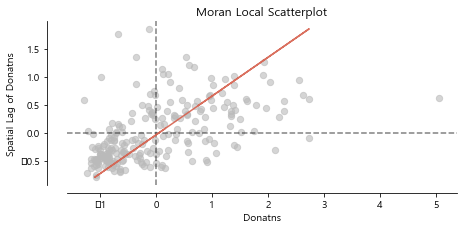

In [29]:
moran1_loc = Moran_Local(y1, w_new)

fig, ax = moran_scatterplot(moran1_loc)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

C:\Users\rkddn\.conda\envs\ox\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\rkddn\.conda\envs\ox\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


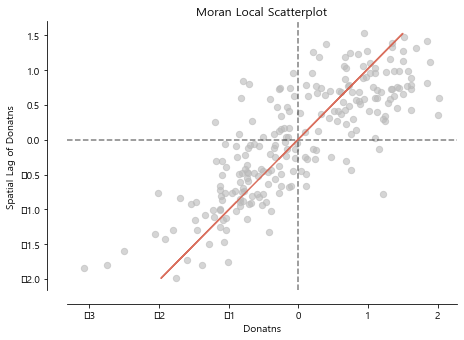

In [30]:
moran2_loc = Moran_Local(y2, w_new)

fig, ax = moran_scatterplot(moran2_loc)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

In [33]:
data_analysis_df = year_data_visu.copy()

data_analysis_df['significant_1'] = moran1_loc.p_sim < 0.05
data_analysis_df['moran1_loc_ql'] = moran1_loc.q

data_analysis_df['significant_2'] = moran2_loc.p_sim < 0.05
data_analysis_df['moran2_loc_ql'] = moran2_loc.q

data_analysis_df

,SGG_AD_CD,SGG_LE_CD,SIDO,SGG,geometry,시군구코드,도서관_1관당_대출권수,SDI,significant_1,moran1_loc_ql,significant_2,moran2_loc_ql
0,11010,11110,서울특별시,종로구,"POLYGON ((126.94890 37.62325, 126.94890 37.623...",11010,235689.000000,-2.358770,True,1,True,3
1,11020,11140,서울특별시,중구,"POLYGON ((126.96155 37.55860, 126.96155 37.558...",11020,118767.000000,-2.346437,True,1,True,3
2,11030,11170,서울특별시,용산구,"POLYGON ((126.94459 37.53378, 126.94460 37.533...",11030,202272.000000,-2.819427,False,1,True,3
3,11040,11200,서울특별시,성동구,"POLYGON ((127.00815 37.54506, 127.00817 37.545...",11040,131997.666667,-2.061491,True,1,True,3
4,11050,11215,서울특별시,광진구,"POLYGON ((127.05622 37.52832, 127.05623 37.528...",11050,308105.000000,-1.741621,True,1,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...
224,38380,48870,경상남도,함양군,"POLYGON ((127.58486 35.55391, 127.58488 35.553...",38380,46953.000000,2.168837,False,3,True,1
225,38390,48880,경상남도,거창군,"POLYGON ((127.67944 35.76850, 127.67945 35.768...",38390,77762.500000,1.578005,False,3,True,1
226,38400,48890,경상남도,합천군,"POLYGON ((127.95323 35.53403, 127.95323 35.534...",38400,46099.000000,2.424807,True,3,True,1
227,39010,50110,제주특별자치도,제주시,"MULTIPOLYGON (((126.94125 33.50648, 126.94125 ...",39010,112618.700000,-0.449342,False,4,False,2


In [48]:
data_analysis_df[(data_analysis_df['significant_1']==True)&(data_analysis_df['significant_2']==True)]

,SGG_AD_CD,SGG_LE_CD,SIDO,SGG,geometry,시군구코드,도서관_1관당_대출권수,SDI,significant_1,moran1_loc_ql,significant_2,moran2_loc_ql
0,11010,11110,서울특별시,종로구,"POLYGON ((126.94890 37.62325, 126.94890 37.623...",11010,235689.000000,-2.358770,True,1,True,3
1,11020,11140,서울특별시,중구,"POLYGON ((126.96155 37.55860, 126.96155 37.558...",11020,118767.000000,-2.346437,True,1,True,3
3,11040,11200,서울특별시,성동구,"POLYGON ((127.00815 37.54506, 127.00817 37.545...",11040,131997.666667,-2.061491,True,1,True,3
4,11050,11215,서울특별시,광진구,"POLYGON ((127.05622 37.52832, 127.05623 37.528...",11050,308105.000000,-1.741621,True,1,True,3
5,11060,11230,서울특별시,동대문구,"POLYGON ((127.02314 37.57803, 127.02314 37.578...",11060,173682.750000,-0.628534,True,1,True,3
11,11120,11380,서울특별시,은평구,"POLYGON ((126.88203 37.59082, 126.88204 37.590...",11120,107702.166667,-0.669731,True,1,True,3
13,11140,11440,서울특별시,마포구,"POLYGON ((126.85363 37.57380, 126.85365 37.573...",11140,204687.250000,-2.890619,True,1,True,3
15,11160,11500,서울특별시,강서구,"POLYGON ((126.76448 37.55537, 126.76450 37.555...",11160,119011.666667,-2.149907,True,1,True,3
17,11180,11545,서울특별시,금천구,"POLYGON ((126.87176 37.48527, 126.87178 37.485...",11180,92223.000000,-1.440544,True,2,True,3
20,11210,11620,서울특별시,관악구,"POLYGON ((126.89895 37.47894, 126.89895 37.478...",11210,81657.400000,-1.629328,True,2,True,3


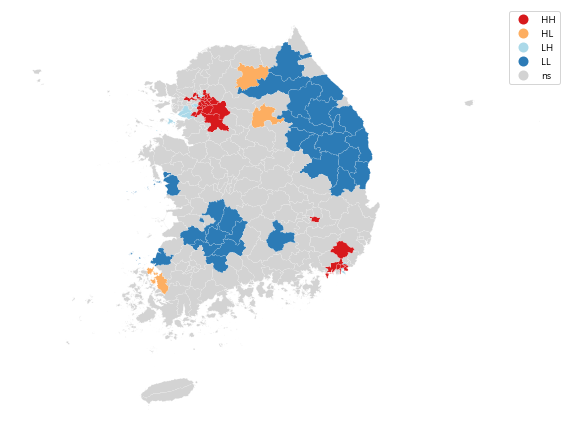

In [40]:
lisa_cluster(moran1_loc, data_analysis_df, p=0.05, figsize = (10,10))
plt.show()

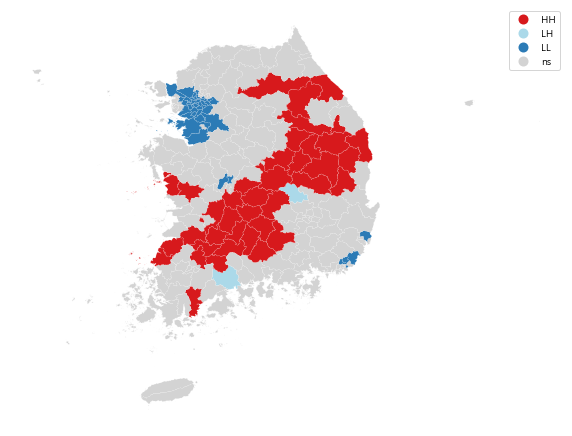

In [41]:
lisa_cluster(moran2_loc, data_analysis_df, p=0.05, figsize = (10,10))
plt.show()